In [1]:
import multiprocessing
import os
import re
import nltk
import gensim.models.word2vec as word2vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

%matplotlib inline

Using TensorFlow backend.
/home/pedro/anaconda3/envs/condaVENV/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
nltk.download("punkt")
nltk.download("stopwords")

In [2]:
dataset = "movie_review_dataset"

temp = []
for folder in os.listdir(dataset):
    folder = os.path.join(dataset, folder)
    if not folder.endswith(".txt"):
        for file in os.listdir(os.path.join(folder, 'pos')):
            with open(os.path.join(folder, 'pos', file), 'r', encoding='utf8') as f:
                text = f.read()
                temp.append([text, True, os.path.join(folder, 'pos', file)])

        for file in os.listdir(os.path.join(folder, 'neg')):
            with open(os.path.join(folder, 'neg', file), 'r', encoding='utf8') as f:
                text = f.read()
                temp.append([text, False, os.path.join(folder, 'neg', file)])

In [3]:
df = pd.DataFrame(temp,columns=['Review', 'Sentiment', 'File']) 
df.head()

,Review,Sentiment,File
0,It would be something to try and tell someone ...,True,movie_review_dataset/part1/pos/3091_10.txt
1,I gave this show a chance because of Jaleel Wh...,True,movie_review_dataset/part1/pos/4918_8.txt
2,"How good is this film? Apparently, good enough...",True,movie_review_dataset/part1/pos/9128_8.txt
3,"This movie is great. Stylish, fun, good acting...",True,movie_review_dataset/part1/pos/7252_10.txt
4,This is one of my most favorite movies of all ...,True,movie_review_dataset/part1/pos/4539_10.txt


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
Review       50000 non-null object
Sentiment    50000 non-null bool
File         50000 non-null object
dtypes: bool(1), object(2)
memory usage: 830.2+ KB


In [5]:
df.describe(include='all')

,Review,Sentiment,File
count,50000,50000,50000
unique,49582,2,50000
top,Loved today's show!!! It was a variety and not...,True,movie_review_dataset/part2/neg/674_3.txt
freq,5,25000,1


In [6]:
df.loc[df['Review'].str.contains("Loved today's show!!!")]

,Review,Sentiment,File
964,Loved today's show!!! It was a variety and not...,True,movie_review_dataset/part1/pos/4420_10.txt
2878,Loved today's show!!! It was a variety and not...,True,movie_review_dataset/part1/pos/4422_10.txt
5079,Loved today's show!!! It was a variety and not...,True,movie_review_dataset/part1/pos/4418_10.txt
7192,Loved today's show!!! It was a variety and not...,True,movie_review_dataset/part1/pos/4419_10.txt
7960,Loved today's show!!! It was a variety and not...,True,movie_review_dataset/part1/pos/4417_10.txt


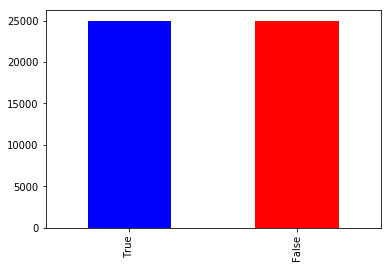

In [7]:
df['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [8]:
num_features = 50

## Build new Word2Vec model

In [29]:
corpus_raw = u""
i =0 
for review in df['Review']:
    if i % 1000 == 0:
        print('Appended {}/{}'.format(i, len(df['Review'])))
    corpus_raw += review
    i+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [34]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)

In [31]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [37]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [39]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

This one did exactly that.
['This', 'one', 'did', 'exactly', 'that']


In [41]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 11,908,918 tokens


In [43]:
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

word2vec_model = word2vec.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

word2vec_model.build_vocab(sentences)

In [47]:
print("Word2Vec vocabulary length:", word2vec_model.corpus_count)

Word2Vec vocabulary length: 488666


In [54]:
word2vec_model.train(sentences=sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.iter)

45080838

In [65]:
if not os.path.exists("trained"):
    os.makedirs("trained")

word2vec_model.save(os.path.join("trained", "word2vec.w2v"))

## Load existing Word2Vec model

In [9]:
word2vec_model = word2vec.Word2Vec.load(os.path.join("trained", "word2vec.w2v"))

In [10]:
word2vec_model.most_similar("woman")

[('girl', 0.8927277326583862),
 ('lady', 0.8728426098823547),
 ('prostitute', 0.8376454710960388),
 ('librarian', 0.8351563811302185),
 ('whore', 0.8246659636497498),
 ('nurse', 0.8230742812156677),
 ('man', 0.8220071792602539),
 ('tramp', 0.8168631196022034),
 ('Amudha', 0.7986037135124207),
 ('stud', 0.7957675457000732)]

In [11]:
word2vec_model.most_similar("man")

[('boy', 0.838233470916748),
 ('loner', 0.835779070854187),
 ('guy', 0.8251751065254211),
 ('woman', 0.8220072388648987),
 ('person', 0.8078900575637817),
 ('soldier', 0.8050024509429932),
 ('coworker', 0.8015088438987732),
 ('bloke', 0.797492504119873),
 ('doctor', 0.7818930745124817),
 ('monk', 0.780976414680481)]

## Build LSTM model

In [12]:
max_words = 200000
max_sequence_length = 300
batch_size = 100 # Nao Aumentar
num_lstm = 50
# num_dense = np.random.randint(100, 150)
# rate_drop_lstm = 0.15 + np.random.rand() * 0.25
# rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [13]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Review'])

sequence = tokenizer.texts_to_sequences(df['Review'])

In [14]:
data = pad_sequences(sequences=sequence, maxlen=max_sequence_length)

In [15]:
nb_words = min(max_words, len(tokenizer.word_index))+1

embedding_matrix = np.zeros((nb_words, num_features))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv[word]

In [16]:
model = Sequential()
model.add(Embedding(nb_words, num_features, weights=[embedding_matrix], trainable=False, input_length=max_sequence_length))
model.add(LSTM(num_lstm, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [60]:
temp = pd.DataFrame(data)
temp['Y'] = df['Sentiment']

X = temp.iloc[:, :-1].values
Y = temp.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [63]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_test, Y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 109s 3ms/step - loss: 0.2805 - acc: 0.8821 - val_loss: 0.2481 - val_acc: 0.8972


In [65]:
model.evaluate(data, df['Sentiment'],batch_size=batch_size)

50000/50000 [==============================] - 42s 836us/step


[0.24768681122362612, 0.89706000244617468]